In [1]:
import importlib
import itertools
import json
import pickle
from pathlib import Path

import Bio
import logomaker
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig
import scipy.stats
import seaborn as sns
from Bio import SeqIO, SeqUtils
from matplotlib.colors import to_rgba
from Modules import plot_utils, utils
from scipy.stats import pearsonr, spearmanr
from statsmodels import api as sm

In [2]:
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

yeastdir = Path("/home/alex/shared_folder/SCerevisiae")
resdir = Path(yeastdir, "results")
model_nuc_name = "model_myco_nuc_2"
model_coh_name = "model_myco_coh_14"
model_pol_name = "model_myco_pol_17"
genome_names = [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]

In [3]:
def get_avg_annot_bychr(file):
    res = {}
    with pyBigWig.open(str(file)) as bw:
        for chr_id in bw.chroms():
            if chr_id.endswith("_rev"):
                res[chr_id[:-4]] = (
                    res[chr_id[:-4]] + np.mean(bw.values(chr_id, 0, -1, numpy=True))
                ) / 2
            else:
                res[chr_id] = np.mean(bw.values(chr_id, 0, -1, numpy=True))
    return {k.split()[0]: v for k, v in res.items()}


def get_gc_bychr(file):
    return {chrom.id: SeqUtils.GC(chrom.seq) for chrom in SeqIO.parse(file, "fasta")}


def genome_name_to_fasta(name):
    if genome_name in ["W303_Mmmyco", "S288c_Mpneumo"]:
        extension = f"genome/{genome_name}.fa"
    elif genome_name in ["FDp92"]:
        extension = f"data/{genome_name}.fa"
    else:
        extension = f"data/MNase-CNN_other-genomes/{genome_name}.fa"
    return Path("/home/alex/shared_folder/SCerevisiae", extension)

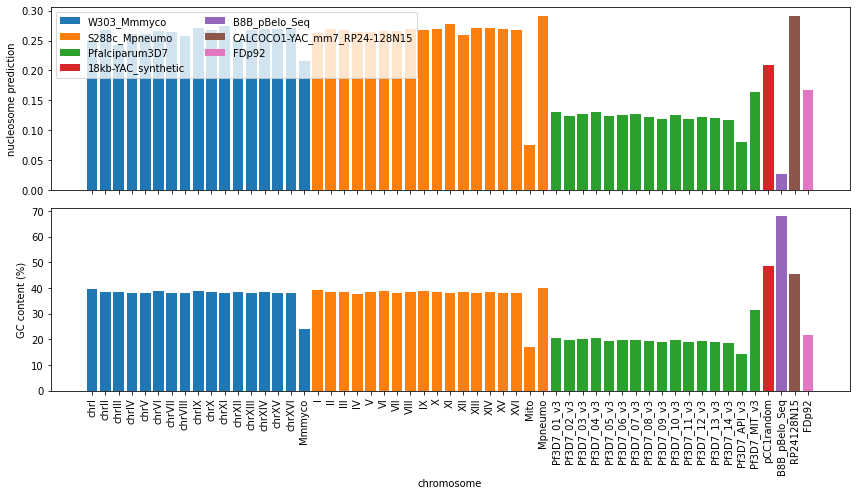

In [131]:
model_name = model_nuc_name
label = "nucleosome"  # polII  # cohesin

fig, axes = plt.subplots(
    2, 1, figsize=(12, 7), facecolor="w", layout="tight", sharex=True
)
for genome_name in [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]:
    if model_name == model_coh_name and genome_name == "18kb-YAC_synthetic":
        continue
    file = Path(resdir, model_name, f"preds_{model_name}_on_{genome_name}.bw")
    file_annot = get_avg_annot_bychr(file)
    axes[0].bar(
        list(file_annot.keys()),
        list(file_annot.values()),
        label=genome_name,
    )
    fastafile = genome_name_to_fasta(genome_name)
    file_gc = get_gc_bychr(fastafile)
    axes[1].bar(
        list(file_gc.keys()),
        list(file_gc.values()),
        label=genome_name,
    )
axes[0].set_ylabel(f"{label} prediction")
axes[1].set_ylabel("GC content (%)")
axes[1].set_xlabel("chromosome")
plt.xticks(rotation=90)
axes[0].legend(loc="upper left", ncol=2)
plt.show()

In [37]:
all_annot_gc = {}
for genome_name in [
    "W303_Mmmyco",
    "S288c_Mpneumo",
    "Pfalciparum3D7",
    "18kb-YAC_synthetic",
    "B8B_pBelo_Seq",
    "CALCOCO1-YAC_mm7_RP24-128N15",
    "FDp92",
]:
    nucfilename = Path(
        resdir, model_nuc_name, f"preds_{model_nuc_name}_on_{genome_name}.bw"
    )
    file_nuc = get_avg_annot_bychr(nucfilename)
    polfilename = Path(
        resdir, model_pol_name, f"preds_mid_{model_pol_name}_on_{genome_name}.bw"
    )
    file_pol = get_avg_annot_bychr(polfilename)
    if genome_name == "18kb-YAC_synthetic":
        file_coh = {"pCC1random": np.nan}
    else:
        cohfilename = Path(
            resdir, model_coh_name, f"preds_{model_coh_name}_on_{genome_name}.bw"
        )
        file_coh = get_avg_annot_bychr(cohfilename)
    fastafilename = genome_name_to_fasta(genome_name)
    file_gc = get_gc_bychr(fastafilename)
    for k in file_nuc.keys():
        all_annot_gc[k] = (
            genome_name,
            file_gc[k],
            file_nuc[k],
            file_pol[k],
            file_coh[k] if k in file_coh.keys() else np.nan,
        )
all_annot_gc = pd.DataFrame(
    all_annot_gc, index=["genome", "gc", "nucleosome", "polII", "cohesin"]
).T

In [39]:
# all_annot_gc.to_csv("/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/table_average_pred_by_chr.csv")

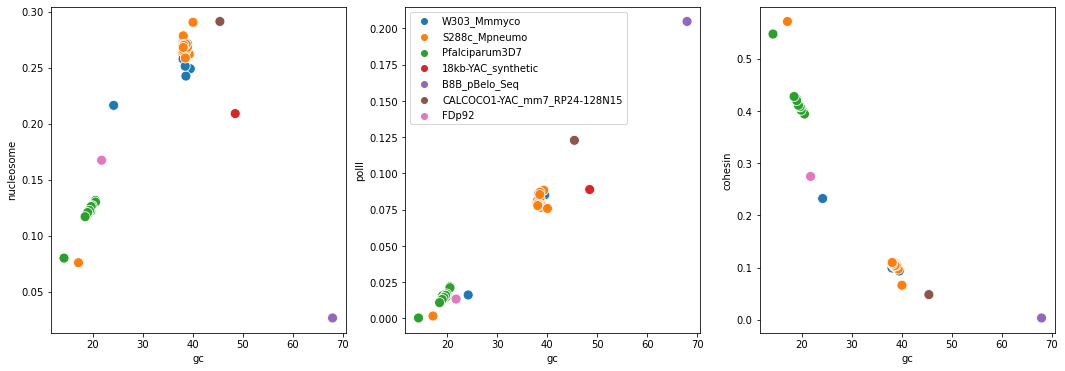

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor="w")
for ax, col in zip(axes, ["nucleosome", "polII", "cohesin"]):
    sns.scatterplot(
        data=all_annot_gc,
        x="gc",
        y=col,
        hue="genome",
        ax=ax,
        legend=col == "polII",
        s=100,
    )
axes[1].legend()

In [29]:
files = {
    "randnuc1": "preds_myco_pneu_v1_nucleosome_random_strictGCrange_indep_10000.npy",
    "randnuc2": "preds_myco_pneu_2_rep2_nucleosome_random_strictGCrange_indep_10000.npy",
    "randnuc3": "preds_myco_pneu_2_rep3_nucleosome_random_strictGCrange_indep_10000.npy",
    "randpol1": "preds_myco_pneu_17_pol_random_strictGCrange_indep_32.npy",
    "randpol2": "preds_myco_pneu_17_rep2_pol_random_strictGCrange_indep_32.npy",
    "randpol3": "preds_myco_pneu_17_rep3_pol_random_strictGCrange_indep_32.npy",
    "randcoh1": "preds_myco_pneu_14_cohesine_random_strictGCrange_indep_32.npy",
    "randcoh2": "preds_myco_pneu_14_rep2_cohesine_random_strictGCrange_indep_32.npy",
    "randcoh3": "preds_myco_pneu_14_rep3_cohesine_random_strictGCrange_indep_32.npy",
}
preds_rand = {
    k: np.load(
        Path(
            yeastdir,
            "results",
            "random_seqs",
            filename,
        )
    ).reshape(21, 2, -1)
    for k, filename in files.items()
}
n_gcs = len(preds_rand["randnuc1"])
gcs = np.linspace(0, 1, n_gcs)
preds_nuc_rand_reps = np.stack([v for k, v in preds_rand.items() if "nuc" in k], axis=2)
preds_pol_rand_reps = np.stack([v for k, v in preds_rand.items() if "pol" in k], axis=2)
preds_coh_rand_reps = np.stack([v for k, v in preds_rand.items() if "coh" in k], axis=2)

In [36]:
rand_summary = {}
rand_summary["gc"] = np.arange(0, 101, 5)
rand_summary["rand_nuc_mean"] = preds_nuc_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_nuc_std"] = preds_nuc_rand_reps[:, 0, 0].std(axis=-1)
rand_summary["rand_pol_mean"] = preds_pol_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_pol_std"] = preds_pol_rand_reps[:, 0, 0].std(axis=-1)
rand_summary["rand_coh_mean"] = preds_coh_rand_reps[:, 0, 0].mean(axis=-1)
rand_summary["rand_coh_std"] = preds_coh_rand_reps[:, 0, 0].std(axis=-1)
df_rand = pd.DataFrame(rand_summary)
# df_rand.to_csv(
#     "/home/alex/shared_folder/SCerevisiae/results/random_seqs/table_preds_myco_rep1_on_random.csv",
#     index=False,
# )

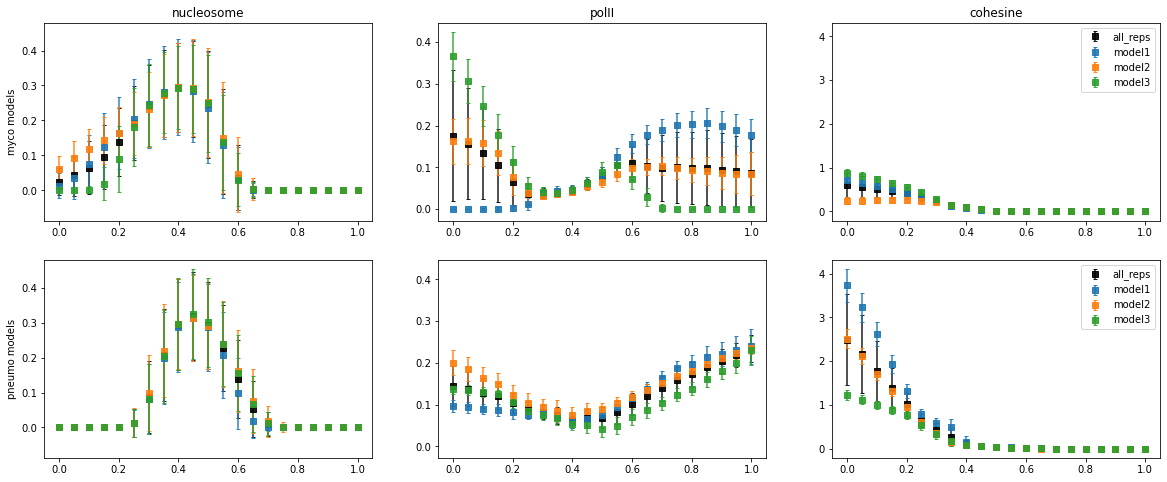

In [276]:
nrow = 2
ncol = 3
fmts = ["bs", "rs", "gs"]
annots = ["nucleosome", "polII", "cohesine"]
ylabels = ["myco models", "pneumo models"]
fig, axes = plt.subplots(nrow, ncol, sharey="col", figsize=(20, 8), facecolor="w")
for col in range(ncol):
    axes[0, col].set_title(annots[col])
for row in range(nrow):
    for col, preds in enumerate(
        [preds_nuc_rand_reps, preds_pol_rand_reps, preds_coh_rand_reps]
    ):
        n_rep = preds.shape[2]
        if row == 0:
            preds = preds[:, 0]
        elif row == 1:
            preds = preds[:, 1]
        # Global average plot
        axes[row, col].errorbar(
            gcs,
            y=preds.reshape(n_gcs, -1).mean(axis=-1),
            yerr=preds.reshape(n_gcs, -1).std(axis=-1),
            fmt="ks",
            alpha=0.9,
            label="all_reps",
            capsize=2,
        )
        # Average plot by model replicate
        means = preds.reshape(n_gcs, n_rep, -1).mean(axis=2)
        stds = preds.reshape(n_gcs, n_rep, -1).std(axis=2)
        for i in range(n_rep):
            axes[row, col].errorbar(
                gcs,
                y=means[:, i],
                yerr=stds[:, i],
                fmt="s",
                alpha=0.9,
                label=f"model{i+1}",
                capsize=2,
            )
    axes[row, 0].set_ylabel(ylabels[row])
    axes[row, col].legend()
# axes[0, 1].set_ylim((-0.05, 1))

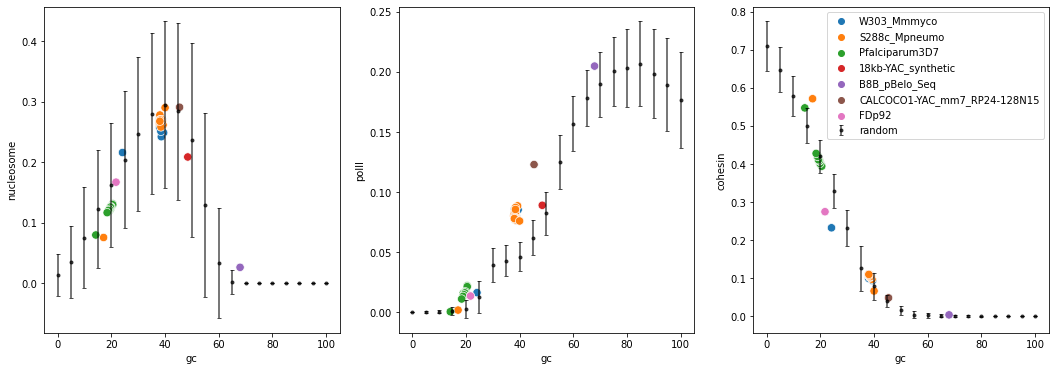

In [213]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor="w")
for ax, col, preds_rand in zip(
    axes,
    ["nucleosome", "polII", "cohesin"],
    [preds_nuc_rand_reps, preds_pol_rand_reps, preds_coh_rand_reps],
):
    ax.errorbar(
        gcs * 100,
        y=preds_rand[:, 0, 0].mean(axis=-1),
        yerr=preds_rand[:, 0, 0].std(axis=-1),
        fmt="k.",
        alpha=0.7,
        label="random",
        capsize=2,
    )
    sns.scatterplot(
        data=all_annot_gc,
        x="gc",
        y=col,
        hue="genome",
        ax=ax,
        legend=(col == "cohesin"),
        s=70,
    )
axes[2].legend()

In [5]:
genome_names

['W303_Mmmyco',
 'S288c_Mpneumo',
 'Pfalciparum3D7',
 '18kb-YAC_synthetic',
 'B8B_pBelo_Seq',
 'CALCOCO1-YAC_mm7_RP24-128N15',
 'FDp92']

In [6]:
from scipy.fft import fft, fftfreq


def merge_preds(file, annot="nuc"):
    if annot == "nuc":
        leftpad, rightpad = 1000, 1000
    elif annot == "pol":
        leftpad, rightpad = 512, 639
    elif annot == "coh":
        leftpad, rightpad = 0, 127
    merge = {}
    with pyBigWig.open(str(file)) as bw:
        for chr_id, length in bw.chroms().items():
            if chr_id.endswith("_rev"):
                leftpad, rightpad = rightpad, leftpad
            indices = np.arange(leftpad, length - rightpad)
            values = bw.values(chr_id, leftpad, length - rightpad, numpy=True)
            if chr_id.endswith("_rev"):
                merge[chr_id[:-4]] = utils.mean_on_index(
                    merge[chr_id[:-4]], (indices, values)
                )
            else:
                merge[chr_id] = (indices, values)
    return merge


def fast_autocorr(y):
    centered_signal = y - np.mean(y)
    corrs = scipy.signal.correlate(centered_signal, centered_signal, mode="full")
    lags = scipy.signal.correlation_lags(y.size, y.size, mode="full")
    corrs /= corrs[lags == 0]
    return lags, corrs

In [7]:
nrl_min, nrl_max = 140, 220
binsize = 2000
nrl_distrib = {}
for genome_name in genome_names:
    merge = merge_preds(
        Path(resdir, model_nuc_name, f"preds_{model_nuc_name}_on_{genome_name}.bw")
    )
    for k, y in merge.items():
        y = y[np.argmax(y > 0) : len(y) - np.argmax(y[::-1] > 0)]
        best_autocorr_list = []
        for y_bin in np.split(y, np.arange(binsize, len(y), binsize)):
            if len(y_bin) < binsize // 2:
                continue
            lags, corrs = fast_autocorr(y_bin)
            # corrs = utils.smooth(corrs, 4)
            # corrs /= corrs[lags == 0]
            best_autocorr = nrl_min + np.argmax(
                corrs[(lags >= nrl_min) & (lags < nrl_max)]
            )
            best_autocorr_list.append(best_autocorr)
        nrl_distrib[k.split()[0]] = (genome_name, best_autocorr_list)
df_nrl = pd.DataFrame(nrl_distrib, index=["genome", "nrl distrib"]).T

/home/alex/mnhn-internship_DeepCNN_ChIP-seq/Modules/utils.py:2962: RuntimeWarning: invalid value encountered in true_divide
  return apply_on_index(lambda n, *args: sum(args) / n, *args, length=length)
/tmp/ipykernel_138622/1370373272.py:31: RuntimeWarning: invalid value encountered in true_divide
  corrs /= corrs[lags == 0]


In [8]:
df_nrl_group = df_nrl.copy()
df_nrl_group.loc["Mmmyco", "genome"] = "Mmmyco"
df_nrl_group.loc["Mpneumo", "genome"] = "Mpneumo"
df_nrl_group.loc["Mito", "genome"] = "Mito"
df_nrl_group.loc["Pf3D7_API_v3", "genome"] = "Pf3D7_API_v3"
df_nrl_group.loc["Pf3D7_MIT_v3", "genome"] = "Pf3D7_MIT_v3"
df_nrl_group = df_nrl_group.groupby("genome").sum()

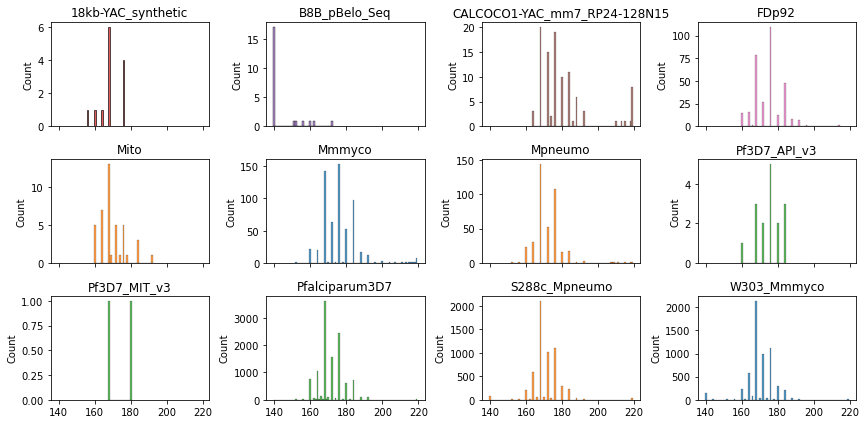

In [9]:
fig, axes = plt.subplots(
    3, 4, figsize=(12, 6), facecolor="w", layout="tight", sharex=True
)
genome_to_idx = {name: i for i, name in enumerate(genome_names)}
for ax, group in zip(axes.flatten(), df_nrl_group.index):
    if group in genome_names:
        genome_name = group
    else:
        genome_name = df_nrl.loc[group, "genome"]
    i = genome_to_idx[genome_name]
    sns.histplot(
        df_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
    )
    ax.set_title(group)

Text(0.5, 0, 'nrl')

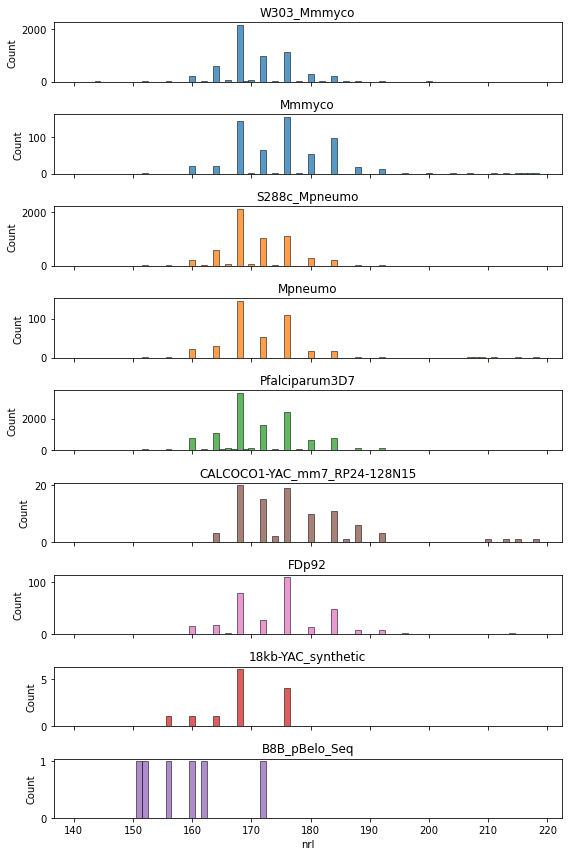

In [10]:
fig, axes = plt.subplots(
    9, 1, figsize=(8, 12), facecolor="w", layout="tight", sharex=True
)
for ax, group in zip(
    axes.flatten(),
    [
        "W303_Mmmyco",
        "Mmmyco",
        "S288c_Mpneumo",
        "Mpneumo",
        "Pfalciparum3D7",
        "CALCOCO1-YAC_mm7_RP24-128N15",
        "FDp92",
        "18kb-YAC_synthetic",
        "B8B_pBelo_Seq",
    ],
):
    if group in genome_names:
        genome_name = group
    else:
        genome_name = df_nrl.loc[group, "genome"]
    i = genome_to_idx[genome_name]
    sns.histplot(
        df_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
        binrange=(nrl_min + 1, nrl_max - 2),
    )
    ax.set_title(group)
ax.set_xlabel("nrl")

In [150]:
datafiles = {
    "labels_myco": "labels_myco_nuc.bw",
    "labels_pneu": "labels_pneu_nuc.bw",
    "mnase_myco": "mnase_myco.bw",
    "mnase_pneu": "mnase_pneumo.bw",
    "mnase_Struhl": "JSerizay_2024_04_12/SRR22031263_mnase-cov.bw",
}

In [155]:
nrl_min, nrl_max = 140, 220
binsize = 2000
nrl_data_distrib = {}
for dataid, datafile in datafiles.items():
    suff = ""
    if "labels" in dataid:
        suff = "_lab"
    if "Struhl" in dataid:
        suff = "_Struhl"
    merge = {}
    with pyBigWig.open(str(Path(yeastdir, "data", datafile))) as bw:
        for chrom in bw.chroms():
            merge[chrom] = bw.values(chrom, 0, -1, numpy=True)
    for k, y in merge.items():
        y = y[np.argmax(y > 0) : len(y) - np.argmax(y[::-1] > 0)]
        best_autocorr_list = []
        for y_bin in np.split(y, np.arange(binsize, len(y), binsize)):
            if len(y_bin) < binsize // 2:
                continue
            lags, corrs = fast_autocorr(y_bin)
            # corrs = utils.smooth(corrs, 4)
            # corrs /= corrs[lags == 0]
            best_autocorr = nrl_min + np.argmax(
                corrs[(lags >= nrl_min) & (lags < nrl_max)]
            )
            best_autocorr_list.append(best_autocorr)
        nrl_data_distrib[k.split()[0] + suff] = (dataid, best_autocorr_list)
df_data_nrl = pd.DataFrame(nrl_data_distrib, index=["dataid", "nrl distrib"]).T

labels_myco {'chrI': 245675, 'chrII': 818518, 'chrIII': 347597, 'chrIV': 1548464, 'chrV': 590080, 'chrVI': 271173, 'chrVII': 1090383, 'chrVIII': 580970, 'chrIX': 429631, 'chrX': 751537, 'chrXI': 678555, 'chrXII': 1103351, 'chrXIII': 932757, 'chrXIV': 777478, 'chrXV': 1091404, 'chrXVI': 932221, 'Mmmyco': 1222199}


/tmp/ipykernel_109793/3925326873.py:28: RuntimeWarning: invalid value encountered in true_divide
  corrs /= corrs[lags == 0]


labels_pneu {'I': 230218, 'II': 813184, 'III': 316620, 'IV': 1531933, 'V': 576874, 'VI': 270161, 'VII': 1090940, 'VIII': 562643, 'IX': 439888, 'X': 745751, 'XI': 666816, 'XII': 1078177, 'XIII': 924431, 'XIV': 784333, 'XV': 1091291, 'XVI': 948066, 'Mpneumo': 817946}
mnase_myco {'chrI': 245675, 'chrII': 818518, 'chrIII': 347597, 'chrIV': 1548464, 'chrV': 590080, 'chrVI': 271173, 'chrVII': 1090383, 'chrVIII': 580970, 'chrIX': 429631, 'chrX': 751537, 'chrXI': 678555, 'chrXII': 1103351, 'chrXIII': 932757, 'chrXIV': 777478, 'chrXV': 1091404, 'chrXVI': 932221, 'Mmmyco': 1222199}
mnase_pneu {'I': 230218, 'II': 813184, 'III': 316620, 'IV': 1531933, 'V': 576874, 'VI': 270161, 'VII': 1090940, 'VIII': 562643, 'IX': 439888, 'X': 745751, 'XI': 666816, 'XII': 1078177, 'XIII': 924431, 'XIV': 784333, 'XV': 1091291, 'XVI': 948066, 'Mpneumo': 817946}
mnase_Struhl {'chrI': 230218, 'chrII': 813184, 'chrIII': 316620, 'chrIV': 1531933, 'chrV': 576874, 'chrVI': 270161, 'chrVII': 1090940, 'chrVIII': 562643, 'c

In [158]:
df_data_nrl_group = df_data_nrl.copy()
df_data_nrl_group.loc["Mmmyco_lab", "dataid"] = "Mmmyco_lab"
df_data_nrl_group.loc["Mpneumo_lab", "dataid"] = "Mpneumo_lab"
df_data_nrl_group.loc["Mmmyco", "dataid"] = "Mmmyco"
df_data_nrl_group.loc["Mpneumo", "dataid"] = "Mpneumo"
df_data_nrl_group.loc["chrXVII_Struhl", "dataid"] = "chrXVII_Struhl"
df_data_nrl_group = df_data_nrl_group.groupby("dataid").sum()

Text(0.5, 0, 'nrl')

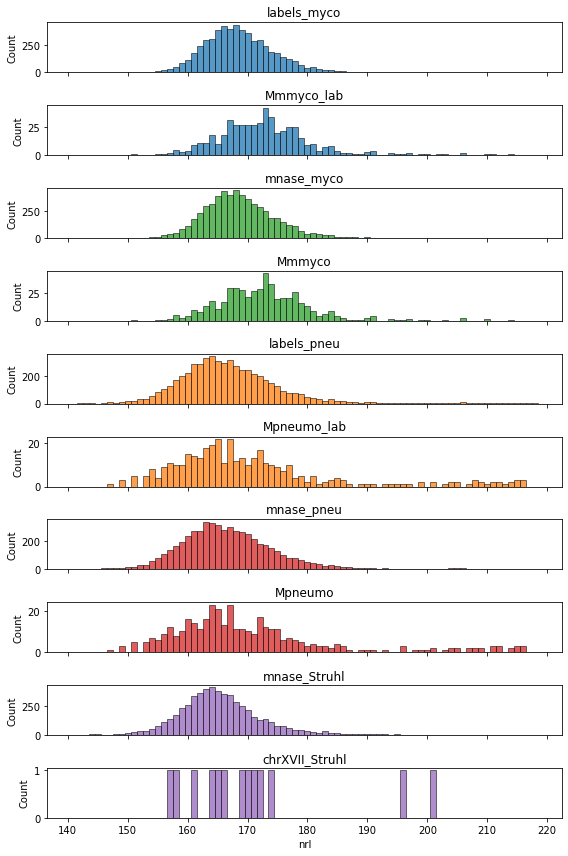

In [165]:
fig, axes = plt.subplots(
    10, 1, figsize=(8, 12), facecolor="w", layout="tight", sharex=True
)
dataid_to_idx = {name: i for i, name in enumerate(datafiles.keys())}
for ax, group in zip(
    axes.flatten(),
    [
        "labels_myco",
        "Mmmyco_lab",
        "mnase_myco",
        "Mmmyco",
        "labels_pneu",
        "Mpneumo_lab",
        "mnase_pneu",
        "Mpneumo",
        "mnase_Struhl",
        "chrXVII_Struhl",
    ],
):
    if group in datafiles.keys():
        dataid = group
    else:
        dataid = df_data_nrl.loc[group, "dataid"]
    i = dataid_to_idx[dataid]
    sns.histplot(
        df_data_nrl_group.loc[group, "nrl distrib"],
        discrete=True,
        ax=ax,
        color=colors[i % len(colors)],
        binrange=(nrl_min + 1, nrl_max - 2),
    )
    ax.set_title(group)
ax.set_xlabel("nrl")

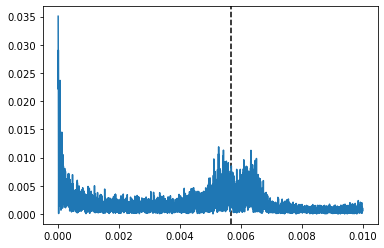

In [15]:
y = merge[list(merge.keys())[0]][1000:]
N = len(y)
T = 1
yf = fft(y)
xf = fftfreq(N, T)[1 : N // 100]
plt.axvline(x=1 / 176, color="k", linestyle="--")
plt.plot(xf, 2.0 / N * np.abs(yf[1 : N // 100]))

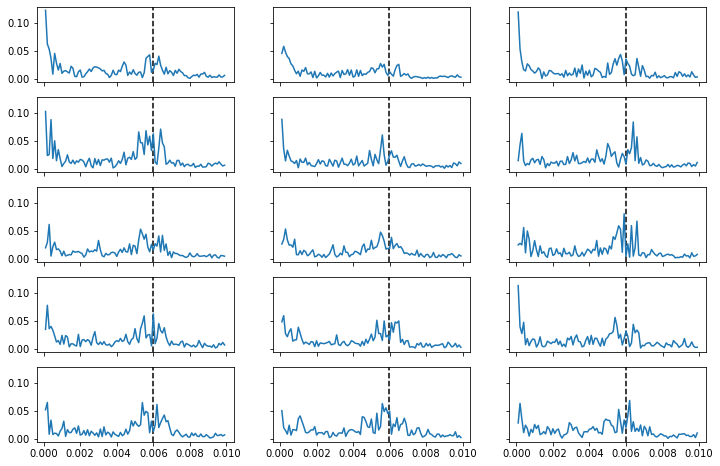

In [21]:
fig, axes = plt.subplots(5, 3, figsize=(12, 8), sharex=True, sharey=True)
for y_bin, ax in zip(np.split(y, np.arange(10000, len(y), 10000)), axes.flatten()):
    N = len(y_bin)
    yf = fft(y_bin)
    xf = fftfreq(N, T)[1 : N // 100]
    ax.axvline(x=1 / 167, color="k", linestyle="--")
    ax.plot(xf, 2.0 / N * np.abs(yf[1 : N // 100]))

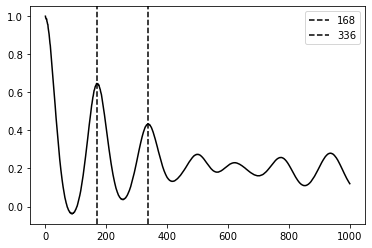

In [13]:
lags, corrs = fast_autocorr(y)
keep = (lags >= 0) & (lags <= 1000)
lags, corrs = lags[keep], corrs[keep]
plt.plot(lags, corrs, color="k")
best_autocorr = 100 + np.argmax(corrs[(lags >= 100) & (lags < 250)])
plt.axvline(best_autocorr, color="k", linestyle="--", label=str(best_autocorr))
best_autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
plt.axvline(best_autocorr2, color="k", linestyle="--", label=str(best_autocorr2))
plt.legend()

<AxesSubplot:ylabel='Count'>

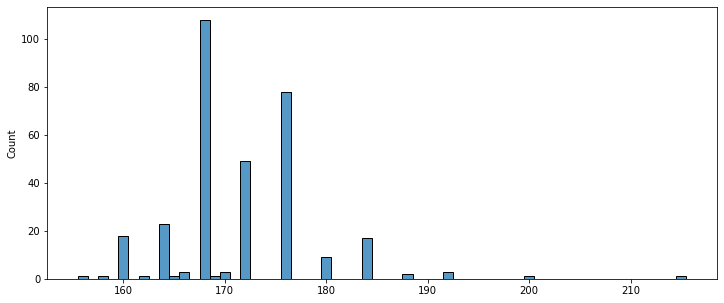

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)
best_autocorr_list = []
for y_bin in np.split(y, np.arange(2000, len(y), 2000)):
    lags, corrs = fast_autocorr(y_bin)
    corrs = utils.smooth(corrs, 4)
    corrs /= corrs[lags == 0]
    keep = (lags >= 0) & (lags <= 1000)
    lags, corrs = lags[keep], corrs[keep]
    # ax.plot(lags, corrs, color="k")
    best_autocorr = 140 + np.argmax(corrs[(lags >= 140) & (lags < 220)])
    best_autocorr_list.append(best_autocorr)
    # ax.axvline(best_autocorr, color="k", linestyle="--", label=str(best_autocorr))
    # best_autocorr2 = 250 + np.argmax(corrs[(lags >= 250) & (lags < 450)])
    # ax.axvline(best_autocorr2, color="k", linestyle="--", label=str(best_autocorr2))
    # ax.legend()
sns.histplot(best_autocorr_list, discrete=True)